<a href="https://colab.research.google.com/github/MetronWard/hands_on_ml/blob/main/Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Data

In [94]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20021010_hard_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets")

In [95]:
def fetch_spam_dataset(ham_url:str=HAM_URL, spam_url:str=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for file_name, url in (("ham.ter.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, file_name)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [96]:
fetch_spam_dataset()

# Obtaining the email data

In [97]:
HAM_DIR = os.path.join(SPAM_PATH, "hard_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")

os.remove(os.path.join(SPAM_DIR, "cmds"))

ham_filenames = [file_name for file_name in os.listdir(HAM_DIR)]
spam_filenames = [file_name for file_name in os.listdir(SPAM_DIR)]

In [98]:
for item in zip(["Ham emails", "Spam emails"], [len(ham_filenames), len(spam_filenames)]):
  print(item)

('Ham emails', 250)
('Spam emails', 500)


In [99]:
import email
import email.policy as policy

def load_email(is_spam:bool, file_name:str, path:str):
  dir = "spam" if is_spam else "hard_ham"
  with open(os.path.join(path, dir, file_name), "rb") as file:
    return email.parser.BytesParser(policy=policy.default).parse(file)

In [100]:
ham_files = [load_email(is_spam=False, file_name=file_name, path=SPAM_PATH) for file_name in ham_filenames]
spam_files = [load_email(is_spam=True, file_name=file_name, path=SPAM_PATH) for file_name in spam_filenames]

# Splitting into train and test set

In [101]:
from sklearn.model_selection import train_test_split
import numpy as np

x = np.array(ham_files + spam_files, dtype=object)
y = np.array([1] * len(ham_files) + [0] * len(spam_files))

x_train_full, x_test, y_train_full, y_test  = train_test_split(x,y, random_state=42, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, random_state=42, test_size=0.2)

In [102]:
x_train.shape

(480,)

In [103]:
x_test.shape

(150,)

In [104]:
from bs4 import BeautifulSoup

def html_to_text(email):
  soup = BeautifulSoup(email)
  links = soup.find_all("a")
  for link in links:
    text = soup.new_tag("p")
    text.string = "HYPERLINK"
    link.replace_with(text)
  return soup.text

In [105]:
def email_to_text_2(email):
    soup = BeautifulSoup(email)
    return soup.text

In [106]:
def email_to_text(email):
  html = None
  for part in email.walk():
    c_type = part.get_content_type()
    if not c_type in ("text/plain", "text/html"):
      continue
    try:
      content = part.get_content()
    except:
      content = str(part.get_payload())
    if c_type == "text/plain":
      return content
    else:
      html = content
  if html:
    return html_to_text(html)

In [107]:
print(email_to_text(x_train[0]))

1) Join the Web's Hottest & Fastest Growing Community
http://www.adclick.ws/p.cfm?o=259&s=pk007

2) Guaranteed to lose 10-12 lbs in 30 days
Slim Patch - Weight Loss Patches
http://www.adclick.ws/p.cfm?o=249&s=pk007

3) Get the Child Support You Deserve - Free Legal Advice
http://www.adclick.ws/p.cfm?o=245&s=pk002

4) Fight The Risk of Cancer - Save Your Lungs
http://www.adclick.ws/p.cfm?o=315&s=pk007

5) Start Your Online Private Photo Album 
http://www.adclick.ws/p.cfm?o=285&s=pk007

Have a Wonderful Day,
Offer Manager
PrizeMama












If you wish to leave this list please use the link below.
http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417




In [108]:
y_train[0]

0

# Defining Pipeline

In [109]:
! pip install urlextract nltk

In [110]:
import nltk
import urlextract
import re
from collections import Counter

stemmer = nltk.PorterStemmer()
url_extractor = urlextract.URLExtract()

In [111]:
from sklearn.base import TransformerMixin, BaseEstimator

class EmailToWordCounter(TransformerMixin, BaseEstimator):
  def __init__(self,
               lower_case=True,
               replace_numbers=True,
               replace_urls=True,
               remove_punctuations=True,
               stemming=True) -> None:
    super().__init__()
    self.lower_case = lower_case
    self.replace_numbers = replace_numbers
    self.replace_urls = replace_urls
    self.stemming = stemming
    self.remove_punctuations = remove_punctuations

  def fit(self, x, y=None):
    return self

  def transform(self, x, y=None):
    x_transformed = []
    for email in x:
      text = email_to_text(email) or ""
      if self.lower_case:
        text = text.lower()
      if self.replace_urls:
        urls = list(set(url_extractor.find_urls(text)))
        urls.sort(key=lambda url: len(url), reverse=True)
        for url in urls:
          text.replace(url, "URL")
      if self.replace_numbers:
        text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
      if self.replace_numbers:
        text = re.sub(r"\W+", " ", text, flags=re.M)
      word_counts = Counter(text.split())
      if self.stemming :
        stemmed_word_count = Counter()
        for word, count in word_counts.items():
          stemmed_word = stemmer.stem(word)
          stemmed_word_count[stemmed_word] += count
        word_counts = stemmed_word_count
        # complete.append(word_counts)
      x_transformed.append(word_counts)
    return np.array(x_transformed)

In [112]:
X_few = x_train[:3]
X_few_wordcounts = EmailToWordCounter().fit_transform(X_few)

In [113]:
X_few_wordcounts

array([Counter({'number': 13, 's': 6, 'http': 6, 'www': 6, 'adclick': 5, 'ws': 5, 'p': 5, 'cfm': 5, 'o': 5, 'pknumber': 5, 'the': 4, 'to': 2, 'day': 2, 'patch': 2, 'you': 2, 'your': 2, 'numbercnumb': 2, 'join': 1, 'web': 1, 'hottest': 1, 'fastest': 1, 'grow': 1, 'commun': 1, 'guarante': 1, 'lose': 1, 'lb': 1, 'in': 1, 'slim': 1, 'weight': 1, 'loss': 1, 'get': 1, 'child': 1, 'support': 1, 'deserv': 1, 'free': 1, 'legal': 1, 'advic': 1, 'fight': 1, 'risk': 1, 'of': 1, 'cancer': 1, 'save': 1, 'lung': 1, 'start': 1, 'onlin': 1, 'privat': 1, 'photo': 1, 'album': 1, 'have': 1, 'a': 1, 'wonder': 1, 'offer': 1, 'manag': 1, 'prizemama': 1, 'if': 1, 'wish': 1, 'leav': 1, 'thi': 1, 'list': 1, 'pleas': 1, 'use': 1, 'link': 1, 'below': 1, 'qve': 1, 'com': 1, 'trim': 1, 'zzzz': 1, 'spamassassin': 1, 'taint': 1, 'org': 1}),
       Counter({'hyperlink': 6, 'free': 4, 'page': 4, 'to': 4, 'or': 4, 'the': 4, 'number': 4, 'save': 3, 'and': 3, 'limit': 3, 'link': 3, 'a': 3, 'softwar': 2, 'much': 2, 'more':

In [114]:
from scipy.sparse import csr_matrix

class WordCounterVector(BaseEstimator, TransformerMixin):

  def __init__(self, vocabulary_size):
    self.vocabulary_size = vocabulary_size

  def fit(self, x, y=None):
    total_count = Counter()
    for word_count in x:
      for word, count in word_count.items():
        total_count[word] += min(count, 10)
    most_common = total_count.most_common()[:self.vocabulary_size]
    self.vocabulary_ = {word:index+1 for index, (word, count) in enumerate(most_common)}
    return self

  def transform(self, x, y=None):
    rows = []
    cols = []
    data = []
    for row, word_counts in enumerate(x):
      for word, count in word_counts.items():
        rows.append(row)
        cols.append(self.vocabulary_.get(word, 0))
        data.append(count)
    return csr_matrix((data, (rows, cols)), shape=(len(x), self.vocabulary_size + 1))

In [115]:
vocab_transformer = WordCounterVector(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [116]:
X_few_vectors.toarray()

array([[ 95,  13,   2,   4,   2,   0,   1,   1,   0,   6,   6],
       [140,   4,   4,   4,   1,   3,   0,   1,   4,   0,   0],
       [170,  17,  11,   5,  12,   5,   6,   5,   3,   0,   0]])

In [117]:
from sklearn.pipeline import Pipeline

processin_pipeline = Pipeline([
    ("email_to_word", EmailToWordCounter()),
    ("wordcount_to_vector", WordCounterVector(vocabulary_size=100))
])

In [118]:
x_train_scaled = processin_pipeline.fit_transform(x_train)
x_test_scaled = processin_pipeline.transform(x_test)
x_valid_scaled = processin_pipeline.transform(x_val)

# Training Model

In [133]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras

model = Sequential([
    Input(shape=x_train_scaled.shape[1:], name="Input_Layer"),
    Dense(101, activation="relu", name="Dense_1"),
    Dense(50, activation="relu", name="Dense_2"),
    Dense(40, activation="relu", name="Dense_3"),
    Dense(10, activation="relu", name="Dense_4"),
    Dense(1, activation="sigmoid", name="Output"),
], name="Spam_Detector")

In [134]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])
history = model.fit(x_train_scaled, y_train, epochs=45, validation_data=(x_valid_scaled,y_val))

Epoch 1/45
15/15 [==============================] - 2s 15ms/step - loss: 2.9061 - accuracy: 0.4625 - val_loss: 2.4065 - val_accuracy: 0.4250
Epoch 2/45
15/15 [==============================] - 0s 4ms/step - loss: 0.9183 - accuracy: 0.6604 - val_loss: 1.2829 - val_accuracy: 0.6333
Epoch 3/45
15/15 [==============================] - 0s 4ms/step - loss: 0.5119 - accuracy: 0.8062 - val_loss: 1.2328 - val_accuracy: 0.6667
Epoch 4/45
15/15 [==============================] - 0s 4ms/step - loss: 0.4179 - accuracy: 0.7979 - val_loss: 0.8320 - val_accuracy: 0.7833
Epoch 5/45
15/15 [==============================] - 0s 5ms/step - loss: 0.3371 - accuracy: 0.8500 - val_loss: 0.7493 - val_accuracy: 0.7917
Epoch 6/45
15/15 [==============================] - 0s 4ms/step - loss: 0.3316 - accuracy: 0.8646 - val_loss: 0.4700 - val_accuracy: 0.8250
Epoch 7/45
15/15 [==============================] - 0s 4ms/step - loss: 0.2894 - accuracy: 0.8771 - val_loss: 0.8066 - val_accuracy: 0.7833
Epoch 8/45
15/15 [=

In [135]:
model.evaluate(x_test_scaled, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 1.0339 - accuracy: 0.9200


[1.0338584184646606, 0.9200000166893005]

In [136]:
preds = model.predict(x_test_scaled)

5/5 [==============================] - 0s 3ms/step


In [137]:
y_test

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1])

In [138]:
preds = (preds >= 0.5)

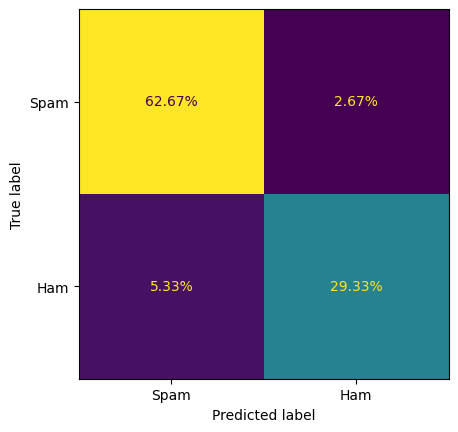

In [140]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=y_test,
        y_pred=preds,
        normalize='all'
    ),
    display_labels=['Spam', 'Ham'],
)

# Plot the confusion matrix with specified formatting
cm.plot(
    values_format='.2%',  # Display values as percentages with two decimal places
    colorbar=False,  # Do not display the color bar
)

# Display the confusion matrix plot
plt.show()

In [141]:
print(classification_report(y_test, preds, target_names=["Spam", "Ham"]) )

              precision    recall  f1-score   support

        Spam       0.92      0.96      0.94        98
         Ham       0.92      0.85      0.88        52

    accuracy                           0.92       150
   macro avg       0.92      0.90      0.91       150
weighted avg       0.92      0.92      0.92       150



In [142]:
model.save("spam_clf.keras")